In [127]:
import pandas as pd
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
import numpy as np
from scipy.optimize import minimize
import scipy.stats as stats
from scipy.stats import poisson
from scipy.stats import norm, mode


In [114]:
# load the data: 
df = pd.read_csv("football.csv", delimiter = ";")
df.columns = df.columns.str.strip().str.replace('"','')

train_df = df[df["GoalsScored"].notnull()].copy()
test_df = df[df["GoalsScored"].isnull()].copy()

features = [
        "X_ScoreRateH", "X_ScoreRateA",
        "X_ConcedeRateH", "X_ConcedeRateA",
        "X_CornerRatioH", "X_CornerRatioA",
        "X_FoulRatioH", "X_FoulRatioA"
]

scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[features])
y_train = train_df["GoalsScored"].values


In [ ]:

with pm.Model() as model:

    # define priors
    intercept = pm.Normal("Intercept", mu=0, sigma=5)
    betas = pm.Normal("betas", mu=0, sigma=5, shape=len(features))
        
    # linear predicotr + loglink
    eta = intercept + pm.math.dot(X_train, betas)
    mu = pm.math.exp(eta)
        
    # likelihood
    y_obs = pm.Poisson("GoalsScored", mu=mu, observed=y_train)
        
    # MCMC sampling 4 chains, 2000 draws, 1000 burn in
    trace = pm.sample(
        draws=2000, tune=1000, 
        chains=4, target_accept=0.95,
        return_inferencedata=True
    )

#print(az.summary(trace))
#az.plot_trace(trace)

In [15]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.999,0.014,0.973,1.026,0.0,0.0,8912.0,5836.0,1.0
betas[0],0.083,0.017,0.052,0.115,0.0,0.0,7600.0,5968.0,1.0
betas[1],0.034,0.018,-0.001,0.066,0.0,0.0,7695.0,5113.0,1.0
betas[2],-0.049,0.017,-0.082,-0.018,0.0,0.0,8638.0,5888.0,1.0
betas[3],0.011,0.016,-0.019,0.041,0.0,0.0,7225.0,4848.0,1.0
betas[4],0.015,0.017,-0.019,0.045,0.0,0.0,8461.0,5779.0,1.0
betas[5],0.000,0.017,-0.032,0.031,0.0,0.0,8702.0,5880.0,1.0
betas[6],-0.052,0.016,-0.080,-0.021,0.0,0.0,8637.0,5759.0,1.0
betas[7],-0.019,0.016,-0.049,0.012,0.0,0.0,8829.0,6064.0,1.0


In [13]:
#### Rhat values: 
summary = az.summary(trace, round_to=4)
print(summary[["r_hat"]])


            r_hat
Intercept  1.0008
betas[0]   1.0001
betas[1]   0.9999
betas[2]   1.0000
betas[3]   1.0002
betas[4]   1.0007
betas[5]   1.0003
betas[6]   0.9998
betas[7]   1.0004


In [4]:
trace.posterior["betas"].shape


(4, 2000, 8)

#### Autocorrelation

In [ ]:
param_name = "Intercept"
lags = 10

samples = trace.posterior[param_name].values # returns in form of [n_chains, n_draws]
print(f"Autocorrelation for '{param_name}' up to lag {lags}:\n")

for i, chain in enumerate(samples):

    print(f"Chain {i}: ")
    # compute autocorrelation values up to the specified lag 
    acf_vals = acf(chain, nlags = lags, fft = True) # aurocorrealtion to lag 10, uwhy using fft ?? 
    print(acf_vals)


Autocorrelation for 'Intercept' up to lag 10:

Chain 0: 
[ 1.         -0.07691085 -0.01042501  0.01764485 -0.05509325  0.06044894
  0.00784395  0.00819875 -0.00477642 -0.02123235 -0.00911712]
Chain 1: 
[ 1.          0.00225663  0.01806934  0.00290892 -0.03709288 -0.02579224
  0.01123075 -0.02174846  0.00290893  0.01632368  0.01010615]
Chain 2: 
[ 1.         -0.03989506  0.01233299 -0.01128188 -0.0122181  -0.0073157
  0.00359883  0.01552321 -0.02263909 -0.0019355  -0.00610344]
Chain 3: 
[ 1.00000000e+00 -1.30537456e-01  2.51373452e-02 -2.02207680e-04
  1.15599028e-02 -6.50692426e-04 -1.10363223e-02  1.01776224e-03
  2.01948888e-02 -2.58829439e-02  5.77406390e-02]


array([[<Axes: title={'center': 'Intercept\n0'}>,
        <Axes: title={'center': 'Intercept\n1'}>,
        <Axes: title={'center': 'Intercept\n2'}>,
        <Axes: title={'center': 'Intercept\n3'}>],
       [<Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>,
        <Axes: title={'center': 'betas\n0, 3'}>],
       [<Axes: title={'center': 'betas\n0, 4'}>,
        <Axes: title={'center': 'betas\n0, 5'}>,
        <Axes: title={'center': 'betas\n0, 6'}>,
        <Axes: title={'center': 'betas\n0, 7'}>],
       [<Axes: title={'center': 'betas\n1, 0'}>,
        <Axes: title={'center': 'betas\n1, 1'}>,
        <Axes: title={'center': 'betas\n1, 2'}>,
        <Axes: title={'center': 'betas\n1, 3'}>],
       [<Axes: title={'center': 'betas\n1, 4'}>,
        <Axes: title={'center': 'betas\n1, 5'}>,
        <Axes: title={'center': 'betas\n1, 6'}>,
        <Axes: title={'center': 'betas\n1, 7'}>],
       [<Ax

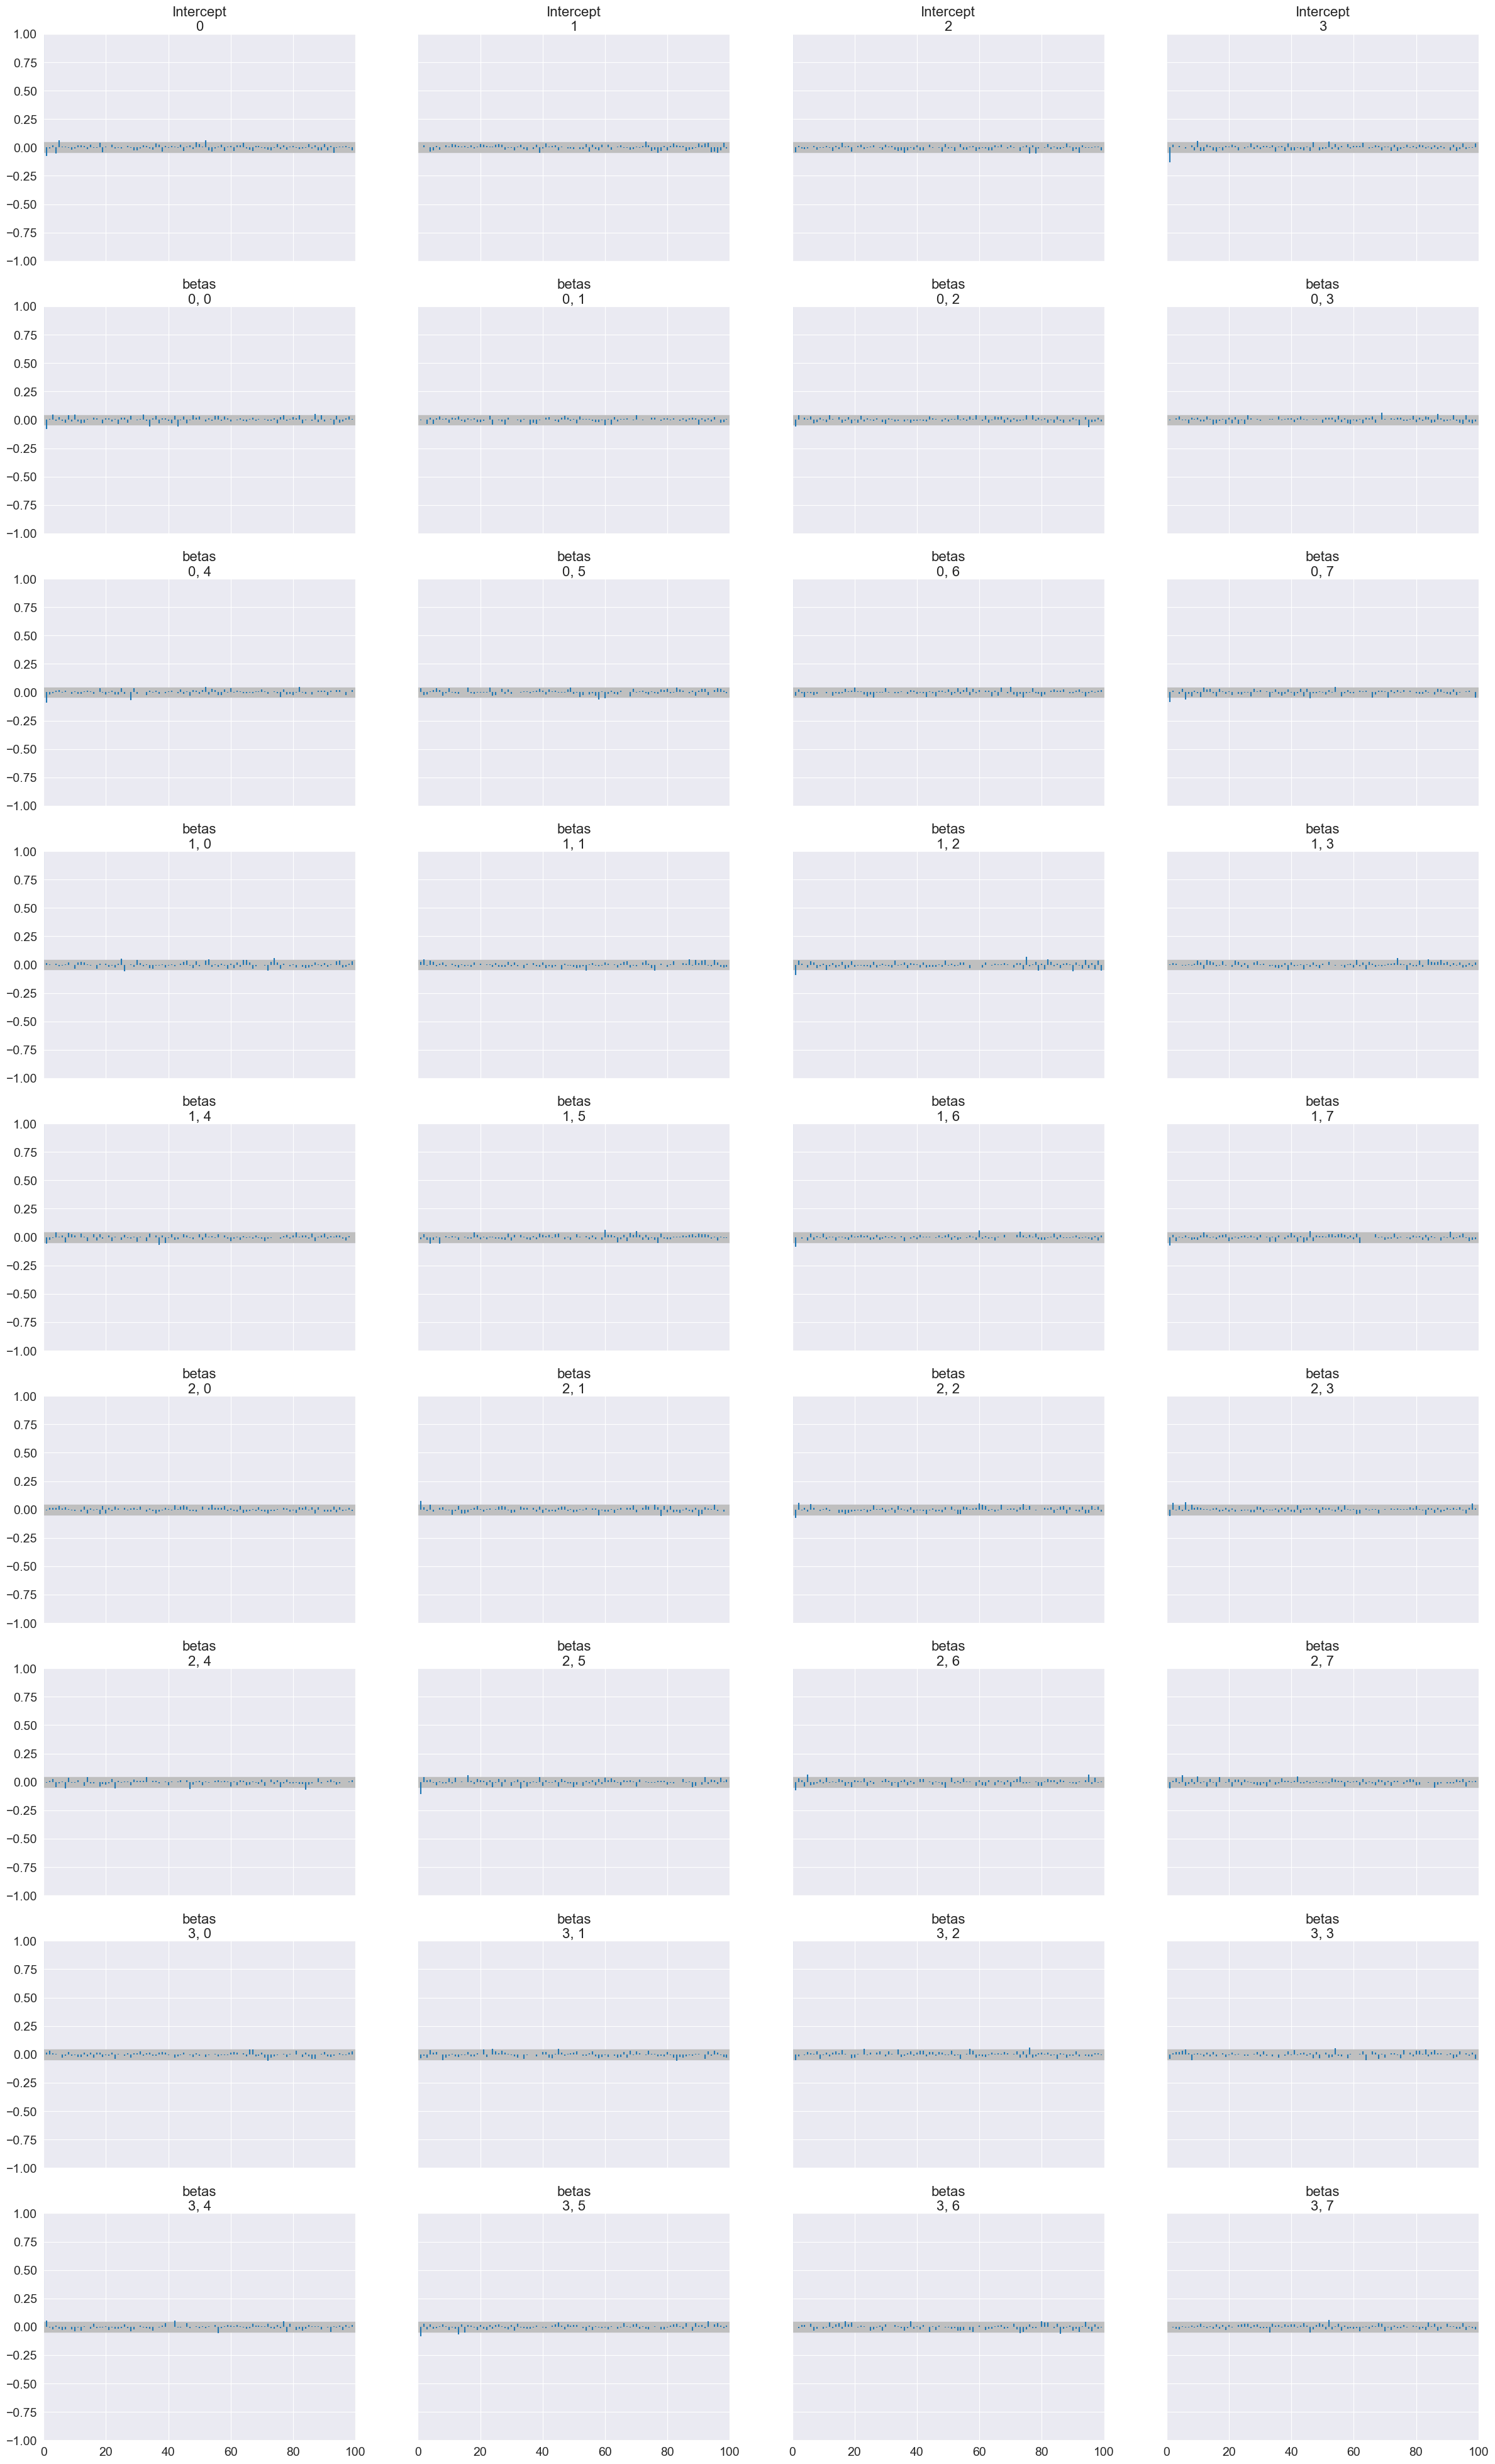

In [32]:
az.plot_autocorr(trace, var_names=["Intercept", "betas"], max_lag=100)


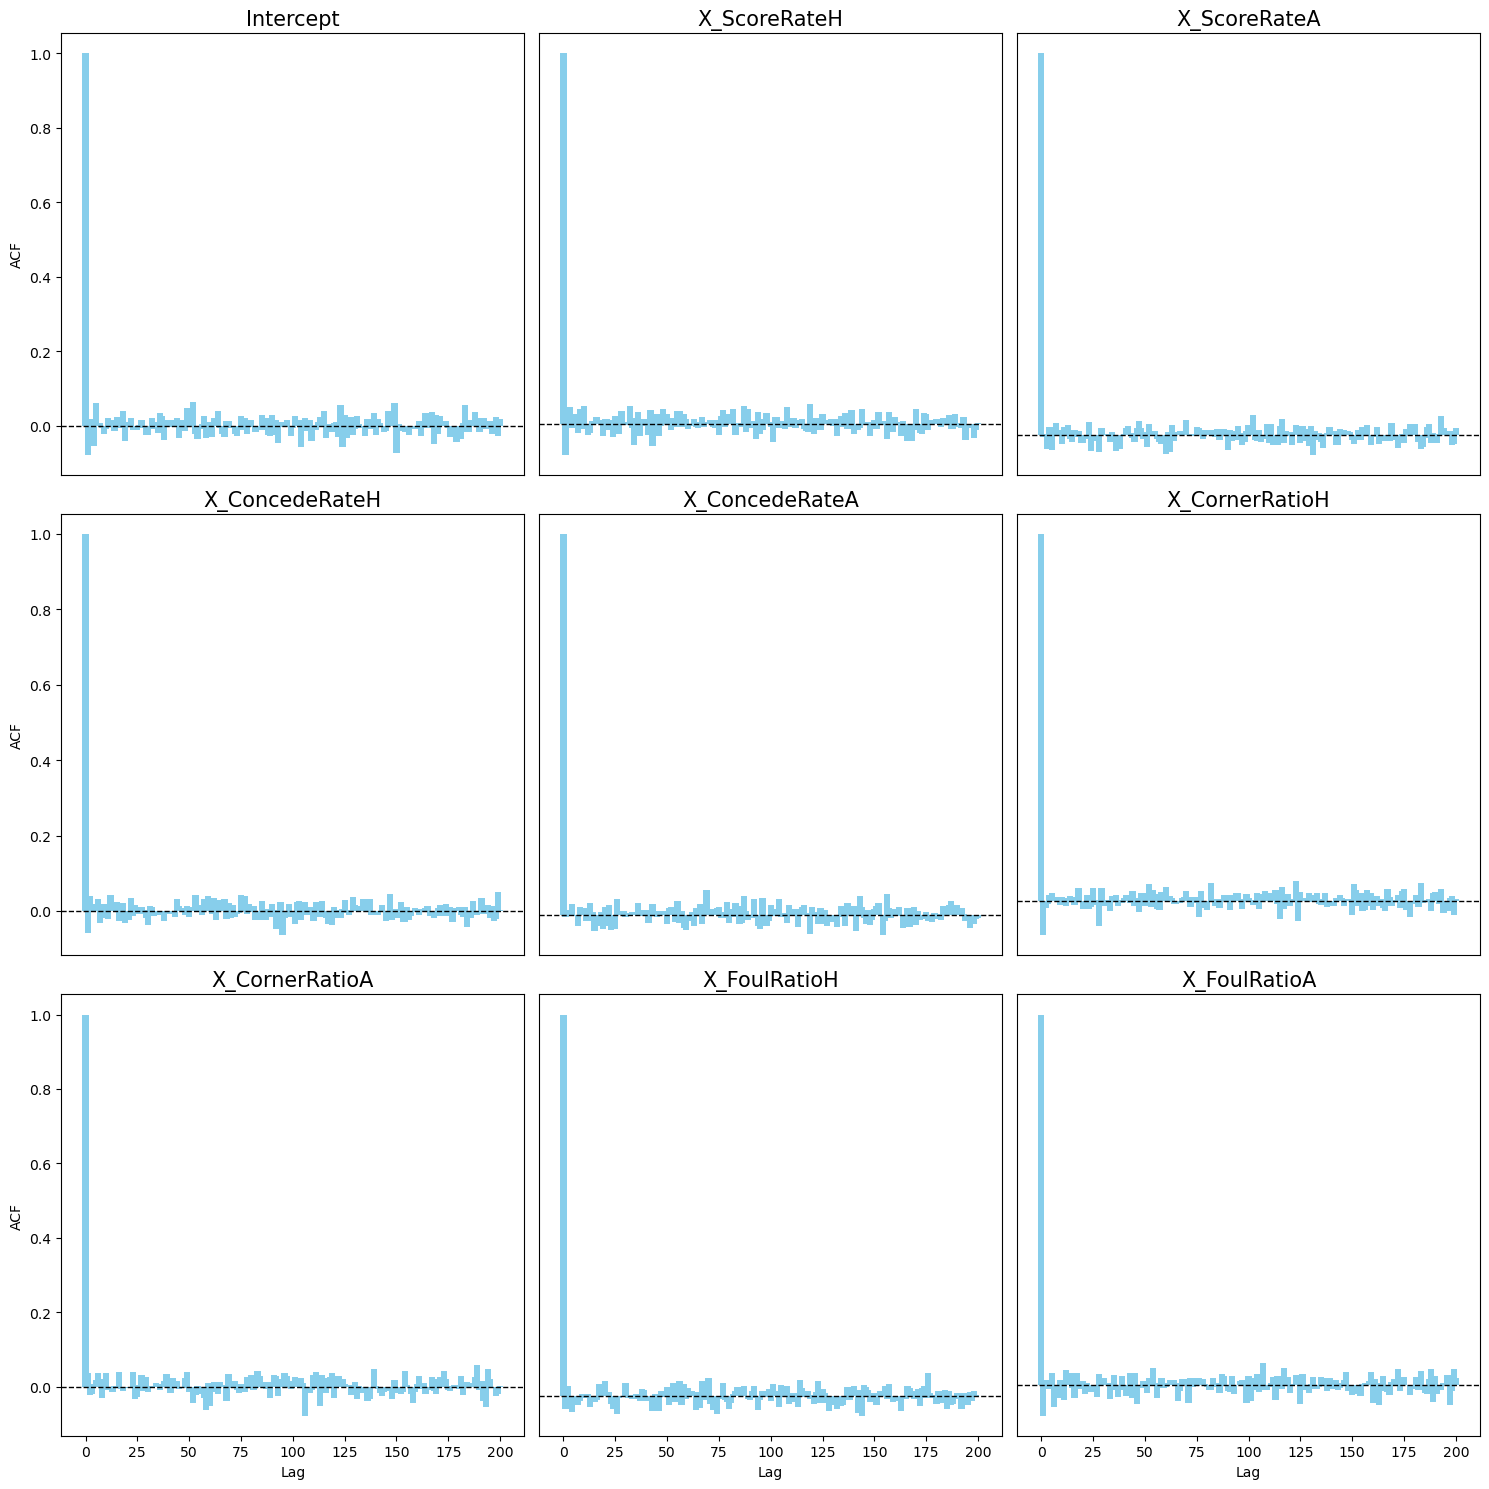

In [93]:
coeff_names = [
    "Intercept",
    "X_ScoreRateH", "X_ScoreRateA",
    "X_ConcedeRateH", "X_ConcedeRateA",
    "X_CornerRatioH", "X_CornerRatioA",
    "X_FoulRatioH", "X_FoulRatioA"
]

lags = 200
colors = sns.color_palette("tab10", len(coeff_names))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx, name in enumerate(coeff_names):
    r, c = divmod(idx, 3)
    ax = axes[r, c]

    # plot only first chain
    if name == "Intercept":
        samples = trace.posterior["Intercept"].values[0]
    else:
        beta_index = idx - 1
        samples = trace.posterior["betas"].isel(betas_dim_0=beta_index).values[0]

    # compute acf
    acf_vals = acf(samples, nlags=lags, fft=True)

    ax.bar(range(0, lags + 1), acf_vals, width=3.0, color="skyblue", alpha=1.0)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    ax.set_title(name, fontsize=15)

    if r == 2:
        ax.set_xlabel("Lag")
    else:
        ax.set_xticks([])

    if c == 0:
        ax.set_ylabel("ACF")
    else:
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("acf_first_chain.pdf", bbox_inches='tight')
plt.show()


### Trace plot

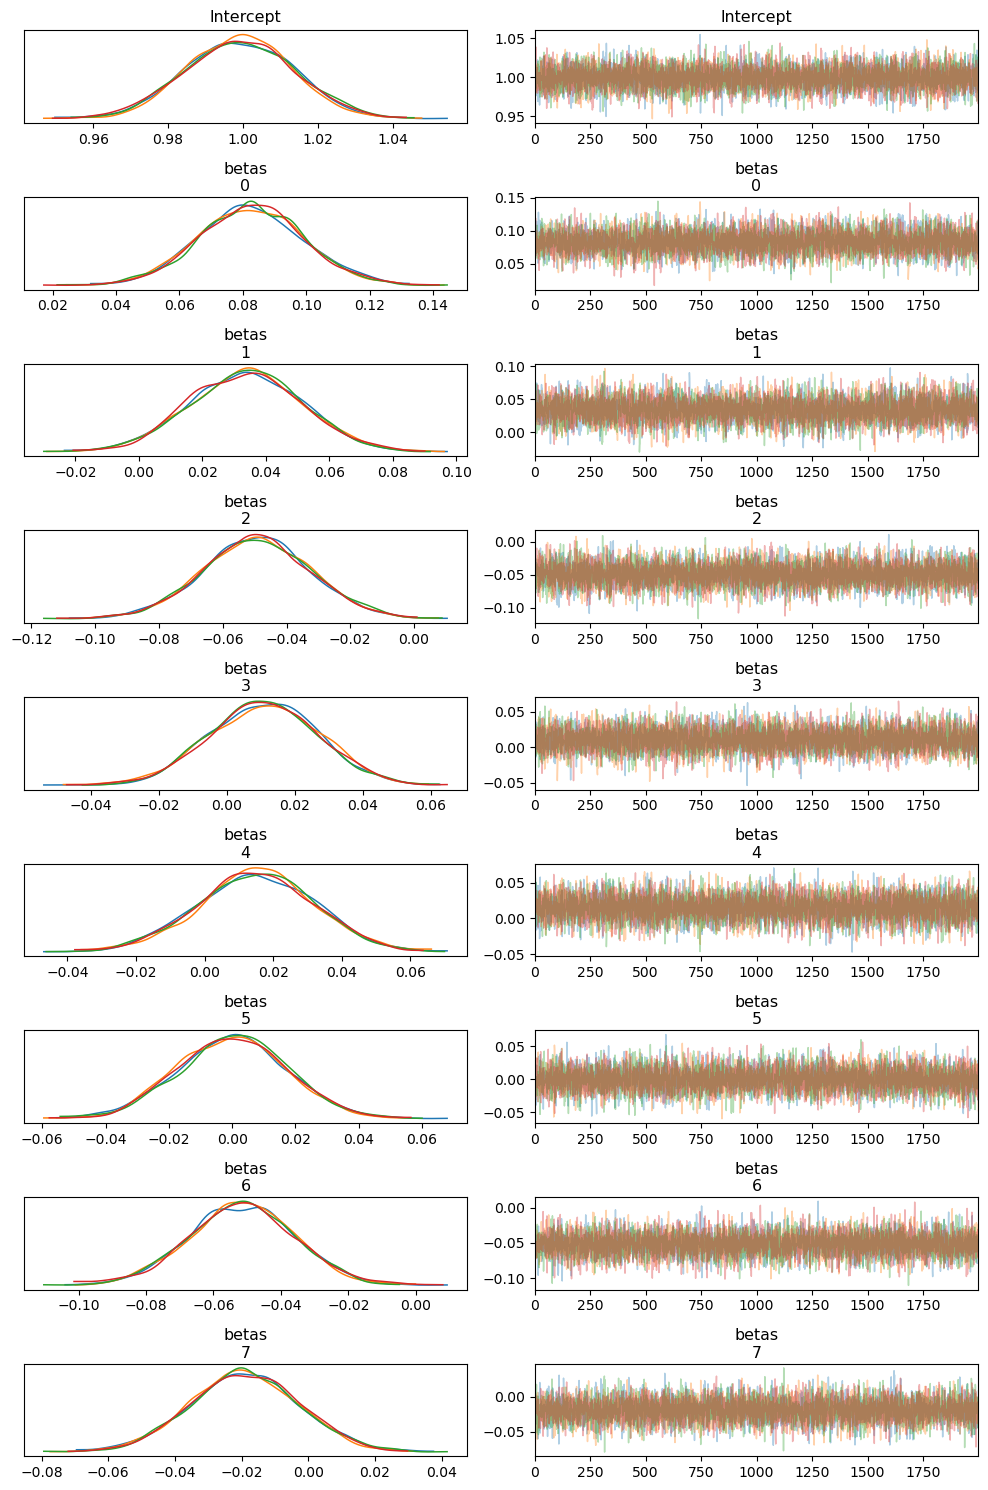

In [66]:
az.plot_trace(trace, var_names=["Intercept", "betas"], figsize=(10, 15), compact=False)
plt.tight_layout()
plt.show()

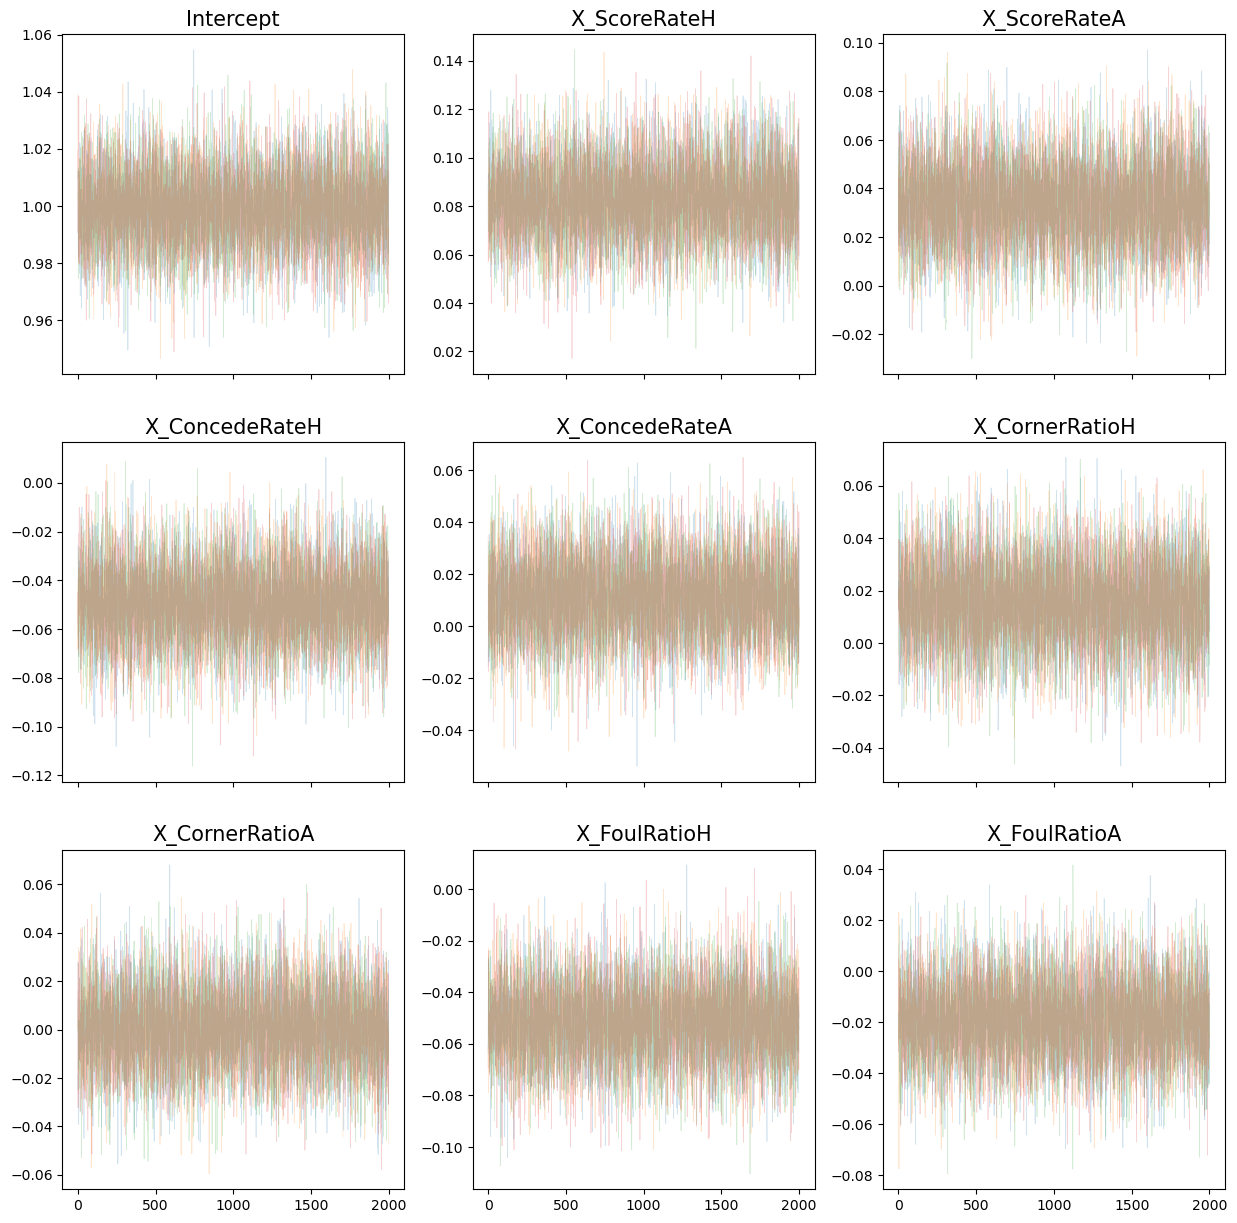

In [79]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True)

for idx, name in enumerate(coeff_names):    

    r, c = divmod(idx, 3)
    ax = axes[r, c]
    ax.set_title(name,  fontsize = 15)
    if name == "Intercept":
        data = trace.posterior["Intercept"] 
    else:
        beta_index = idx - 1
        data = trace.posterior["betas"].isel(betas_dim_0=beta_index)  

    for chain_id in range(data.shape[0]):
        y = data[chain_id].values
        x = range(len(y))
        ax.plot(x, y, linewidth=0.5, label=f"Chain {chain_id}", alpha = 0.2)

plt.savefig("trace.pdf")

### Explanatory variables 

In [80]:
az.summary(trace, var_names=["Intercept", "betas"], round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.00,0.01,0.97,1.03,0.0,0.0,8911.97,5836.38,1.0
betas[0],0.08,0.02,0.05,0.11,0.0,0.0,7599.96,5968.04,1.0
betas[1],0.03,0.02,-0.00,0.07,0.0,0.0,7695.40,5112.62,1.0
betas[2],-0.05,0.02,-0.08,-0.02,0.0,0.0,8638.43,5888.20,1.0
betas[3],0.01,0.02,-0.02,0.04,0.0,0.0,7225.14,4848.21,1.0
betas[4],0.02,0.02,-0.02,0.04,0.0,0.0,8461.44,5778.98,1.0
betas[5],0.00,0.02,-0.03,0.03,0.0,0.0,8702.07,5880.45,1.0
betas[6],-0.05,0.02,-0.08,-0.02,0.0,0.0,8637.20,5758.53,1.0
betas[7],-0.02,0.02,-0.05,0.01,0.0,0.0,8828.69,6063.84,1.0


0.9726269642094885 1.0259600948848788
0.051590222768582834 0.11474963368540053
-0.0006006108762163296 0.06599598058685055
-0.08160269575095962 -0.0180281423371559
-0.018908648672599924 0.040570473227226546
-0.01925494420115559 0.044911858251167315
-0.03227380022092552 0.0313402278428145
-0.08016997075929638 -0.021207580735152703
-0.04869636303961045 0.012008309768309503


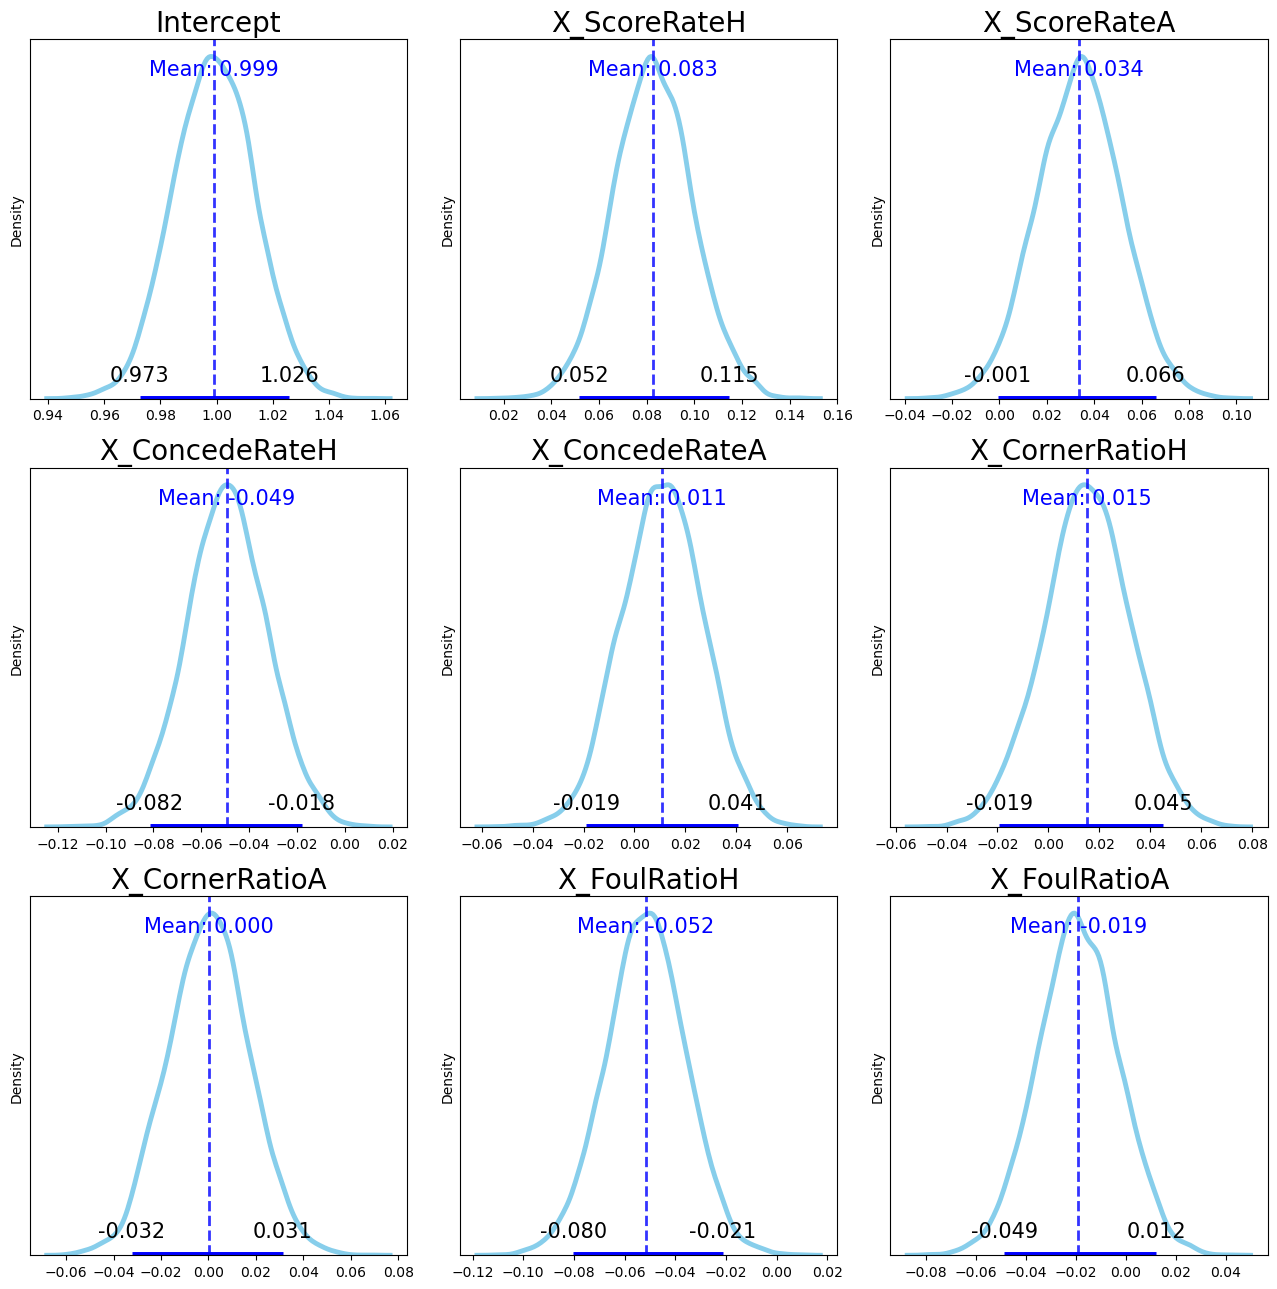

In [158]:
fig, axes = plt.subplots(3, 3, figsize = (13, 13))

for idx, name in enumerate(coeff_names):

    r, c = divmod(idx, 3)
    ax = axes[r, c]

    if name == "Intercept": 
        samples = trace.posterior["Intercept"].values.flatten()

    else: 

        beta_index = idx - 1
        samples = trace.posterior["betas"].isel(betas_dim_0 = beta_index).values.flatten()

    mean_val = samples.mean()
    hdi_low, hdi_high = az.hdi(samples, hdi_prob = 0.94)
    print(hdi_low, hdi_high)
    sns.kdeplot(samples, ax=ax, linewidth=3.5, color="skyblue")
    ax.axvline(mean_val, color="blue", linestyle="--", linewidth=2, alpha = 0.8)
    ax.hlines(y=0, xmin=hdi_low, xmax=hdi_high, color="blue", linewidth=5)

    ax.text(mean_val, ax.get_ylim()[1] * 0.9, f"Mean: {mean_val:.3f}", 
        ha='center', fontsize=15, color='blue')

    ax.text(hdi_low, ax.get_ylim()[1] * 0.05, f"{hdi_low:.3f}", 
            ha='center', fontsize=15, color='black')

    ax.text(hdi_high, ax.get_ylim()[1] * 0.05, f"{hdi_high:.3f}", 
            ha='center', fontsize=15, color='black')


    ax.set_title(name, fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel("")
    #ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig("posterior_explanatory.pdf", bbox_inches="tight")
plt.show()

#### Part2

In [115]:
def neg_log_posterior(theta, X, y, sigma): 

    eta = X @ theta
    mu = np.exp(eta)
    # return -np.sum(y * eta - mu) + 0.5 * np.sum(theta**2) / sigma **2
    return -np.sum(y * eta - mu) + 0.5 * np.sum(theta[1:]**2) / sigma ** 2
    # return -np.sum(y * eta - mu) + 0.5 * np.sum(theta[1:]**2) / sigma**2


def grad_neg_log_posterior(theta, X, y, sigma):

    eta = X @ theta 
    mu = np.exp(eta)
    grad = X.T @ (mu - y)
    grad[1:] += theta[1:] / sigma**2 # dont regularize the intercept
    return grad

def hessian_neg_log_posterior(theta, X, y, sigma):

    eta = X @ theta 
    mu = np.exp(eta)
    W = np.diag(mu) 
    H = X.T @ W @ X
    H[1:, 1:] += np.eye(len(theta) - 1) / sigma**2
    return H

sigma = 5.0 

X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
theta_init = np.zeros(X_train.shape[1])

result = minimize(fun=neg_log_posterior, x0=theta_init, jac=grad_neg_log_posterior,
    hess=hessian_neg_log_posterior, args=(X_train, y_train, sigma), method='trust-ncg', options={'maxiter': 100})

theta_map = result.x
# print(theta_map)
hessian_at_map = hessian_neg_log_posterior(theta_map, X_train, y_train, sigma)
cov_approx = np.linalg.inv(hessian_at_map)


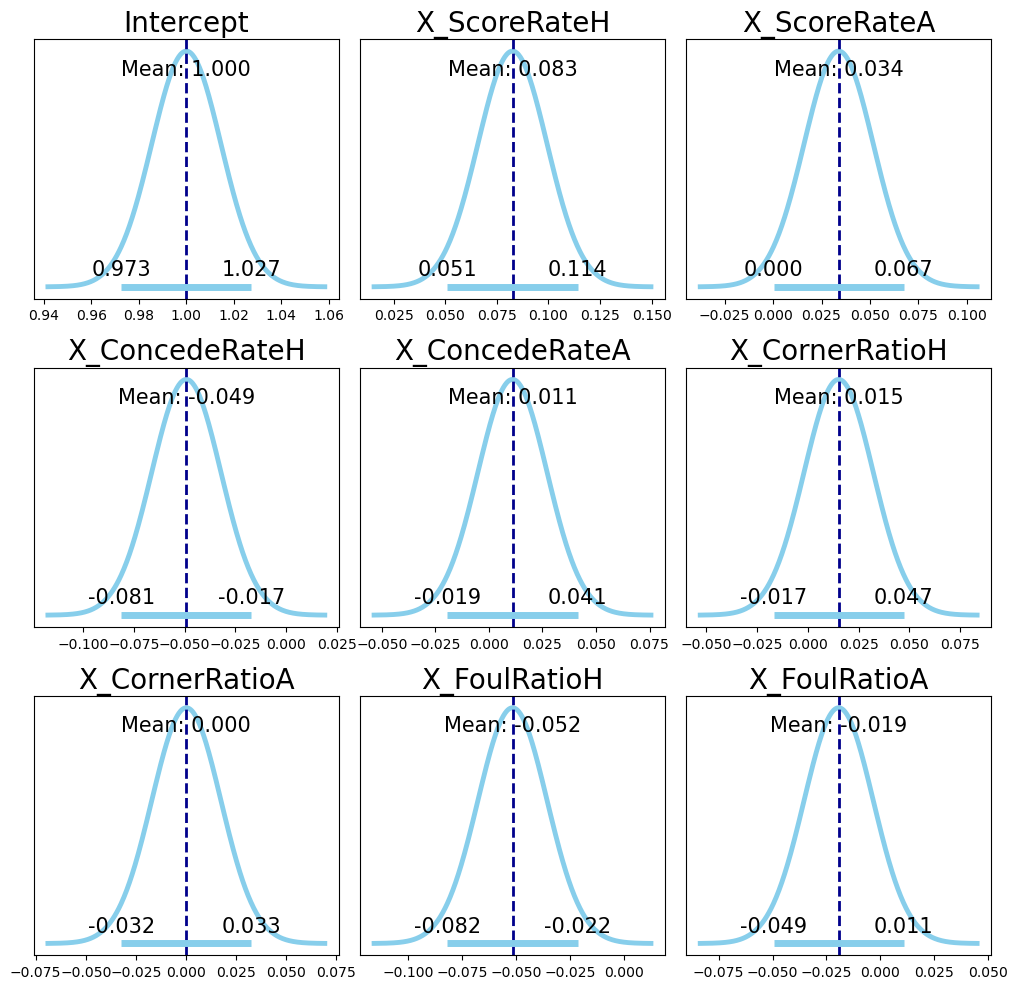

In [157]:
fig, axes = plt.subplots(3, 3, figsize = (10, 10))

for idx, name in enumerate(coeff_names): 

    r, c = divmod(idx, 3)
    ax = axes[r, c]

    # mean and sd
    mean = theta_map[idx]
    std = np.sqrt(cov_approx[idx, idx])

    # gaussian curve
    x_vals = np.linspace(mean - 4*std, mean + 4*std, 500)
    pdf_vals = norm.pdf(x_vals, loc=mean, scale=std)

    hdi_low, hdi_high = norm(loc=mean, scale=std).interval(0.94)

    ax.plot(x_vals, pdf_vals, color="skyblue", linewidth=3.5)
    ax.axvline(mean, color="darkblue", linestyle="--", linewidth=2)
    ax.hlines(y=0, xmin=hdi_low, xmax=hdi_high, color="skyblue", linewidth=5)

    ax.text(mean, max(pdf_vals) * 0.9, f"Mean: {mean:.3f}", ha='center', fontsize=15)
    ax.text(hdi_low, max(pdf_vals) * 0.05, f"{hdi_low:.3f}", ha='center', fontsize=15)
    ax.text(hdi_high, max(pdf_vals) * 0.05, f"{hdi_high:.3f}", ha='center', fontsize=15)

    ax.set_title(name, fontsize=20)
    ax.set_yticks([])
    ax.set_xlabel("")


plt.tight_layout()
plt.savefig("laplace_posterior.pdf", bbox_inches="tight")
plt.show()

#### Make point predictioin

In [145]:
theta_map

X_test = scaler.transform(test_df[features])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


n_samples = 1000
theta_samples = np.random.multivariate_normal(theta_map, cov_approx, size=n_samples)
lambdas = np.exp(X_test @ theta_samples.T) 

y_samples = np.random.poisson(lambdas) 
y_pred_squared = y_samples.mean(axis=1)
y_pred_absolute = np.median(y_samples, axis=1)
y_pred_accuracy = mode(y_samples, axis=1).mode.flatten()



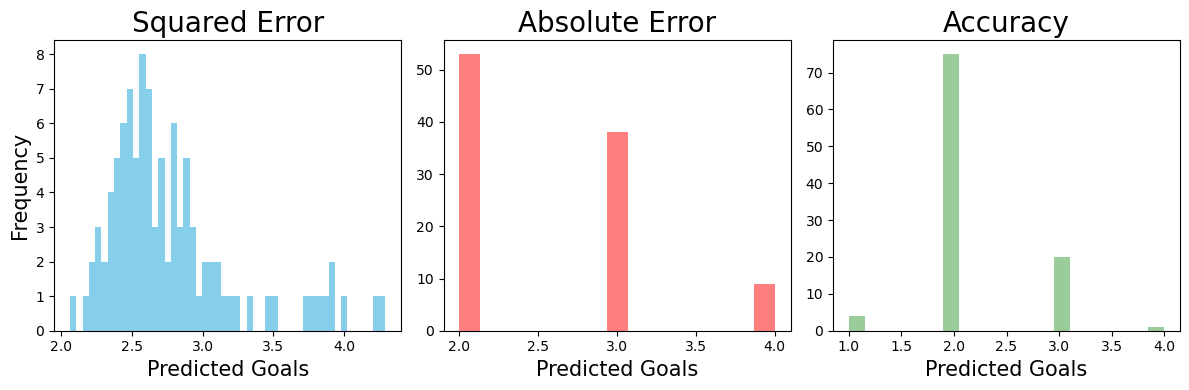

In [156]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(y_pred_squared, bins=50, color='skyblue')
plt.title('Squared Error', fontsize = 20)
plt.xlabel('Predicted Goals', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

plt.subplot(1,3,2)
plt.hist(y_pred_absolute, bins=15, color='red', alpha = 0.5)
plt.title('Absolute Error', fontsize = 20)
plt.xlabel('Predicted Goals', fontsize = 15 )

plt.subplot(1,3,3)
plt.hist(y_pred_accuracy, bins=20, color='green', alpha = 0.4)
plt.title('Accuracy', fontsize = 20)
plt.xlabel('Predicted Goals', fontsize = 15)

plt.tight_layout()
plt.savefig("point_estimate.pdf")
plt.show()